## Overview
This notebook presents a complete, transparent analysis of Battery Energy
Storage System (BESS) operational data. All calculations and transformations
are performed directly in this notebook to clearly demonstrate methodology,
assumptions, and analytical reasoning.

The objectives are to:
- Load and validate BESS operational data
- Compute daily charge and discharge energy per enclosure
- Visualize enclosure-level performance trends
- Identify underperforming enclosures for further investigation

## 1. Environment Setup

This analysis uses standard Python data science libraries commonly employed
in energy analytics and power systems performance monitoring.

The dataset is provided as parquet files and stored locally outside the
GitHub repository in accordance with assignment instructions.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Plot settings
plt.style.use("default")
sns.set_context("notebook")

# Configuration (kept external in actual package)
DATA_FOLDER = Path("20221108")
INTERVAL_HOURS = 0.25  # 15-minute intervals



## 2. Data Loading

The operational dataset consists of parquet exports from a utility-scale
BESS installation composed of multiple inverters and battery enclosures.

Each inverter has two DC inputs, with multiple battery enclosures connected
per input depending on configuration.


In [2]:
parquet_files = list(DATA_FOLDER.glob("*.parquet"))
print(f"Found {len(parquet_files)} parquet files")

dfs = []
for f in parquet_files:
    print(f"Loading {f.name}")
    df = pd.read_parquet(f)
    df["source_file"] = f.stem  # date identifier
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

print("Combined DataFrame shape:", combined_df.shape)


Found 3 parquet files
Loading 20221108.parquet
Loading 20221030.parquet
Loading 20221104.parquet
Combined DataFrame shape: (7200, 2813)


## 3. Data Validation & Preprocessing

Before performing calculations, the dataset is validated to ensure:
- Timestamps are properly formatted
- Power values are numeric
- Missing or invalid records are handled
- Look at basic statistics for key metrics:
    - BESS SOC (%) [BESS]
    - BESS active power (kW) [BESS]
- Summarize data per file to check consistency.
- Create a simple row number as a proxy for time for plotting.


In [3]:
# Drop completely empty columns
combined_df = combined_df.dropna(axis=1, how="all")

combined_df.info()
combined_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Columns: 2812 entries, BESS SOC (%) [BESS] to source_file
dtypes: float64(2647), int64(164), object(1)
memory usage: 154.5+ MB


,BESS SOC (%) [BESS],BESS active power (kW) [BESS],External active power setpoint (kW) [BESS],BESS1 DC Input Power (kW) [Battery Inverter 1APCS1],BESS1 DC Input Power (kW) [Battery Inverter 1APCS2],BESS1 DC Input Power (kW) [Battery Inverter 1APCS3],BESS1 DC Input Power (kW) [Battery Inverter 1APCS4],BESS1 DC Input Power (kW) [Battery Inverter 1APCS5],BESS1 DC Input Power (kW) [Battery Inverter 1APCS6],BESS1 DC Input Power (kW) [Battery Inverter 1APCS7],...,System state of charge (%) [Battery system 4B7BAT4],System state of charge (%) [Battery system 4B8BAT1],System state of charge (%) [Battery system 4B8BAT2],System state of charge (%) [Battery system 4B8BAT3],System state of charge (%) [Battery system 4B8BAT4],System state of charge (%) [Battery system 4B9BAT1],System state of charge (%) [Battery system 4B9BAT2],System state of charge (%) [Battery system 4B9BAT3],System state of charge (%) [Battery system 4B9BAT4],source_file
0,13.815675,43633.351562,44014.832031,381.533325,381.716675,371.399994,378.283325,255.600006,391.533325,247.833328,...,68.716667,15.0,17.000000,15.0,16.0,5.0,5.8,8.0,5.00,20221108
1,13.707540,59600.449219,61923.000000,520.733337,516.833313,506.366669,514.400024,344.533325,532.549988,337.000000,...,68.000000,15.0,17.000000,15.0,16.0,5.0,5.0,7.3,4.65,20221108
2,13.589683,76008.078125,77763.265625,657.133362,656.766663,638.116638,643.233337,436.350006,679.783325,429.033325,...,68.000000,15.0,17.000000,15.0,16.0,5.0,5.0,7.0,4.00,20221108
3,13.473063,96273.210938,98415.437500,833.349976,828.483337,808.166687,812.016663,548.816650,840.933350,538.299988,...,68.000000,15.0,17.000000,15.0,16.0,5.0,5.0,7.0,4.00,20221108
4,13.261905,120121.812500,123204.781250,1044.216675,1043.050049,1011.150024,1017.450012,688.500000,881.616638,672.450012,...,67.783333,15.0,16.583334,15.0,16.0,5.0,5.0,7.0,4.00,20221108


In [4]:
metrics = [
    'BESS SOC (%) [BESS]',
    'BESS active power (kW) [BESS]'
]

print("=== Overall Summary ===")
combined_df[metrics].describe()


=== Overall Summary ===


,BESS SOC (%) [BESS],BESS active power (kW) [BESS]
count,7197.000000,7197.000000
mean,42.267980,-4131.855958
std,40.175720,101578.802025
min,1.625132,-202043.578125
25%,5.520958,-4292.071777
50%,17.662880,68.099998
75%,92.741554,361.825012
max,99.621826,200691.109375


## Step 4: Visualize BESS State of Charge (SOC)

- Plot the SOC over time for each source file.
    - SOC is the ratio of the remaining stored energy to the maximum energy the battery can hold, indicating its current "fuel" level.
- Each line represents a different data file.
- Row number is used as a proxy for time since timestamps may not be standardized.


/var/folders/b7/39bdz8110nx8k7gsyhz6vmhh0000gn/T/ipykernel_31291/1581146123.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df["row_number"] = combined_df.index


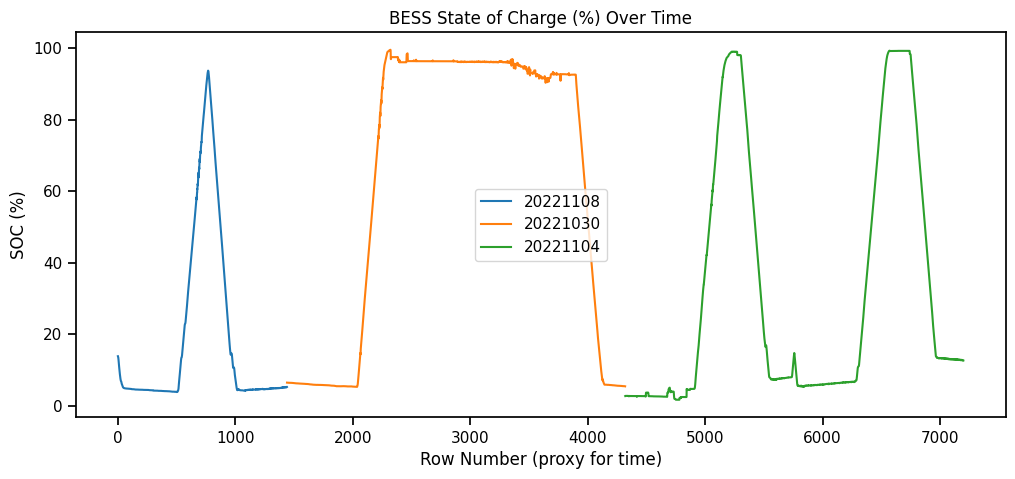

In [5]:
combined_df["row_number"] = combined_df.index

plt.figure(figsize=(12, 5))
for f in combined_df["source_file"].unique():
    subset = combined_df[combined_df["source_file"] == f]
    plt.plot(subset["row_number"], subset["BESS SOC (%) [BESS]"], label=f)

plt.title("BESS State of Charge (%) Over Time")
plt.xlabel("Row Number (proxy for time)")
plt.ylabel("SOC (%)")
plt.legend()
plt.show()


## Step 5: Visualize BESS Active Power

- Similar to SOC, plot active power (kW) over time.
- This gives a visual understanding of charging/discharging patterns.


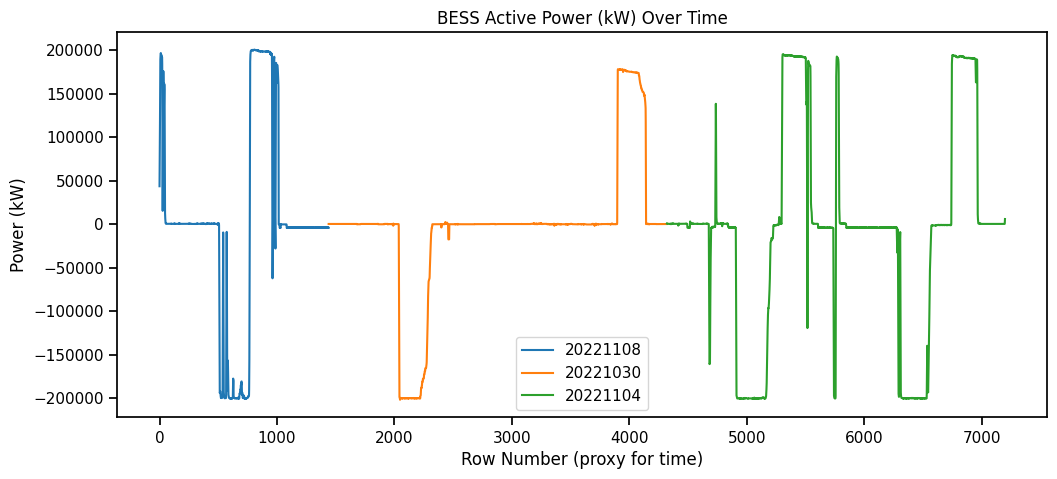

In [6]:
plt.figure(figsize=(12, 5))
for f in combined_df["source_file"].unique():
    subset = combined_df[combined_df["source_file"] == f]
    plt.plot(subset["row_number"], subset["BESS active power (kW) [BESS]"], label=f)

plt.title("BESS Active Power (kW) Over Time")
plt.xlabel("Row Number (proxy for time)")
plt.ylabel("Power (kW)")
plt.legend()
plt.show()


## Step 6: Identify DC Input Power Columns

- Identify all columns corresponding to DC Input Power from the battery inverters.
- These columns are used for calculating energy charged and discharged.


In [7]:
dc_columns = [
    col for col in combined_df.columns
    if "DC Input Power (kW)" in col
]

print(f"Found {len(dc_columns)} DC input columns")
dc_columns[:5]


Found 144 DC input columns


['BESS1 DC Input Power (kW) [Battery Inverter 1APCS1]',
 'BESS1 DC Input Power (kW) [Battery Inverter 1APCS2]',
 'BESS1 DC Input Power (kW) [Battery Inverter 1APCS3]',
 'BESS1 DC Input Power (kW) [Battery Inverter 1APCS4]',
 'BESS1 DC Input Power (kW) [Battery Inverter 1APCS5]']

## Step 7: Calculate Daily Energy

- Compute energy per row for each DC input column:  
  `Energy (kWh) = Power (kW) * Interval (hours)`
- Separate **charging** (negative power) and **discharging** (positive power) energy.
- Sum energy for each source file (representing daily energy).
- Combine results into a single DataFrame with MultiIndex columns:
    - Level 0: DC input column
    - Level 1: 'charged_kWh' or 'discharged_kWh'


In [8]:
daily_energy = {}

for col in dc_columns:
    # Convert power (kW) → energy (kWh)
    energy = combined_df[col] * INTERVAL_HOURS

    charged = energy[energy < 0].abs()
    discharged = energy[energy > 0]

    daily_charged = charged.groupby(combined_df["source_file"]).sum()
    daily_discharged = discharged.groupby(combined_df["source_file"]).sum()

    daily_energy[col] = pd.DataFrame({
        "charged_kWh": daily_charged,
        "discharged_kWh": daily_discharged
    })

daily_energy_df = pd.concat(daily_energy, axis=1)

daily_energy_df.head()


BESS1 DC Input Power (kW) [Battery Inverter 1APCS1]  \
                                                    charged_kWh   
source_file                                                       
20221030                                         100739.921127    
20221104                                         245217.958526    
20221108                                         102059.470717    

                            \
            discharged_kWh   
source_file                  
20221030     115698.108360   
20221104     215783.420705   
20221108     114718.816701   

            BESS1 DC Input Power (kW) [Battery Inverter 1APCS2]  \
                                                    charged_kWh   
source_file                                                       
20221030                                         106695.579182    
20221104                                         244980.991637    
20221108                                         101609.250090    

                            \
            discharged_kWh   
source_file                  
20221030     112629.987512   
20221104     215865.070847   
20221108     115659.629469   

            BESS1 DC Input Power (kW) [Battery Inverter 1APCS3]  \
                                                    charged_kWh   
source_file                                                       
20221030                                          81888.775111    
20221104                                         242543.879051    
20221108                                          98213.566769    

                            \
            discharged_kWh   
source_file                  
20221030     110026.154123   
20221104     216616.624967   
20221108     106342.145793   

            BESS1 DC Input Power (kW) [Battery Inverter 1APCS4]  \
                                                    charged_kWh   
source_file                                                       
20221030                                          93278.245901    
20221104                                         243336.254137    
20221108                                         100136.562621    

                            \
            discharged_kWh   
source_file                  
20221030     113293.945738   
20221104     216902.933684   
20221108     112273.779213   

            BESS1 DC Input Power (kW) [Battery Inverter 1APCS5]  \
                                                    charged_kWh   
source_file                                                       
20221030                                          76321.999996    
20221104                                         167240.583224    
20221108                                          76804.608286    

                            ...  \
            discharged_kWh  ...   
source_file                 ...   
20221030      78587.929379  ...   
20221104     148283.266885  ...   
20221108      84184.808387  ...   

            BESS2 DC Input Power (kW) [Battery Inverter 4BPCS5]  \
                                                    charged_kWh   
source_file                                                       
20221030                                                   NaN    
20221104                                         123056.299993    
20221108                                          77810.508197    

                            \
            discharged_kWh   
source_file                  
20221030      22393.541672   
20221104     115414.279217   
20221108      79412.329210   

            BESS2 DC Input Power (kW) [Battery Inverter 4BPCS6]  \
                                                    charged_kWh   
source_file                                                       
20221030                                          72409.837598    
20221104                                         165888.941965    
20221108                                          74676.132364    

                            \
            discharged_kWh   
source_file    

## Step 8: Analyze and Visualize Discharged Energy per Inverter

- Extract **discharged energy** from the DataFrame.
- Simplify column names to inverter names only.
- Group DC inputs by inverter.
- Plot a heatmap showing **daily discharged energy per inverter**.
- Identify top 5 BESS enclosures with lowest charged and discharged energy to flag potential outliers.


In [9]:
# Select discharged energy columns explicitly
discharged = daily_energy_df.loc[
    :,
    daily_energy_df.columns.get_level_values(1) == "discharged_kWh"
].copy()

discharged.head()


,BESS1 DC Input Power (kW) [Battery Inverter 1APCS1],BESS1 DC Input Power (kW) [Battery Inverter 1APCS2],BESS1 DC Input Power (kW) [Battery Inverter 1APCS3],BESS1 DC Input Power (kW) [Battery Inverter 1APCS4],BESS1 DC Input Power (kW) [Battery Inverter 1APCS5],BESS1 DC Input Power (kW) [Battery Inverter 1APCS6],BESS1 DC Input Power (kW) [Battery Inverter 1APCS7],BESS1 DC Input Power (kW) [Battery Inverter 1APCS8],BESS1 DC Input Power (kW) [Battery Inverter 1APCS9],BESS1 DC Input Power (kW) [Battery Inverter 1BPCS1],...,BESS2 DC Input Power (kW) [Battery Inverter 4APCS9],BESS2 DC Input Power (kW) [Battery Inverter 4BPCS1],BESS2 DC Input Power (kW) [Battery Inverter 4BPCS2],BESS2 DC Input Power (kW) [Battery Inverter 4BPCS3],BESS2 DC Input Power (kW) [Battery Inverter 4BPCS4],BESS2 DC Input Power (kW) [Battery Inverter 4BPCS5],BESS2 DC Input Power (kW) [Battery Inverter 4BPCS6],BESS2 DC Input Power (kW) [Battery Inverter 4BPCS7],BESS2 DC Input Power (kW) [Battery Inverter 4BPCS8],BESS2 DC Input Power (kW) [Battery Inverter 4BPCS9]
,discharged_kWh,discharged_kWh,discharged_kWh,discharged_kWh,discharged_kWh,discharged_kWh,discharged_kWh,discharged_kWh,discharged_kWh,discharged_kWh,...,discharged_kWh,discharged_kWh,discharged_kWh,discharged_kWh,discharged_kWh,discharged_kWh,discharged_kWh,discharged_kWh,discharged_kWh,discharged_kWh
source_file,,,,,,,,,,,,,,,,,,,,,
20221030,115698.108360,112629.987512,110026.154123,113293.945738,78587.929379,1826.470836,70518.541651,74665.399745,78341.462415,111622.554449,...,81928.158266,110651.220695,110220.158479,402311.990689,79797.158202,22393.541672,77092.900018,76293.799980,76727.520707,70350.079170
20221104,215783.420705,215865.070847,216616.624967,216902.933684,148283.266885,37316.079139,146147.349779,144644.745917,154365.462217,213793.270730,...,154454.650301,213031.600065,206974.708140,219259.083427,150483.554307,115414.279217,146991.995846,141900.458176,144416.341595,138922.379271
20221108,114718.816701,115659.629469,106342.145793,112273.779213,84184.808387,61333.387515,78917.016764,83204.946167,86097.941413,115615.837591,...,86282.424767,113542.562512,110646.404367,102217.462563,83152.433232,79412.329210,81566.671024,83894.733283,81231.729371,69965.087302


In [10]:
# Extract inverter names from original DC column names
def extract_inverter(col_name):
    return col_name.split("[")[-1].replace("]", "")

# Assign inverter names as column headers
discharged.columns = [extract_inverter(c[0]) for c in discharged.columns]

discharged.head()


,Battery Inverter 1APCS1,Battery Inverter 1APCS2,Battery Inverter 1APCS3,Battery Inverter 1APCS4,Battery Inverter 1APCS5,Battery Inverter 1APCS6,Battery Inverter 1APCS7,Battery Inverter 1APCS8,Battery Inverter 1APCS9,Battery Inverter 1BPCS1,...,Battery Inverter 4APCS9,Battery Inverter 4BPCS1,Battery Inverter 4BPCS2,Battery Inverter 4BPCS3,Battery Inverter 4BPCS4,Battery Inverter 4BPCS5,Battery Inverter 4BPCS6,Battery Inverter 4BPCS7,Battery Inverter 4BPCS8,Battery Inverter 4BPCS9
source_file,,,,,,,,,,,,,,,,,,,,,
20221030,115698.108360,112629.987512,110026.154123,113293.945738,78587.929379,1826.470836,70518.541651,74665.399745,78341.462415,111622.554449,...,81928.158266,110651.220695,110220.158479,402311.990689,79797.158202,22393.541672,77092.900018,76293.799980,76727.520707,70350.079170
20221104,215783.420705,215865.070847,216616.624967,216902.933684,148283.266885,37316.079139,146147.349779,144644.745917,154365.462217,213793.270730,...,154454.650301,213031.600065,206974.708140,219259.083427,150483.554307,115414.279217,146991.995846,141900.458176,144416.341595,138922.379271
20221108,114718.816701,115659.629469,106342.145793,112273.779213,84184.808387,61333.387515,78917.016764,83204.946167,86097.941413,115615.837591,...,86282.424767,113542.562512,110646.404367,102217.462563,83152.433232,79412.329210,81566.671024,83894.733283,81231.729371,69965.087302


In [11]:
# Transpose -> groupby -> transpose back
discharged_grouped = discharged.T.groupby(level=0).sum().T

discharged_grouped.head()


,Battery Inverter 1APCS1,Battery Inverter 1APCS2,Battery Inverter 1APCS3,Battery Inverter 1APCS4,Battery Inverter 1APCS5,Battery Inverter 1APCS6,Battery Inverter 1APCS7,Battery Inverter 1APCS8,Battery Inverter 1APCS9,Battery Inverter 1BPCS1,...,Battery Inverter 4APCS9,Battery Inverter 4BPCS1,Battery Inverter 4BPCS2,Battery Inverter 4BPCS3,Battery Inverter 4BPCS4,Battery Inverter 4BPCS5,Battery Inverter 4BPCS6,Battery Inverter 4BPCS7,Battery Inverter 4BPCS8,Battery Inverter 4BPCS9
source_file,,,,,,,,,,,,,,,,,,,,,
20221030,229199.337451,224223.566749,219546.741786,225455.224991,155560.574978,1826.470836,70518.541651,149729.224788,152369.879153,220248.600284,...,166169.483199,220683.795742,222865.371130,404040.007356,162251.612252,46946.612462,152547.079323,157551.166790,153757.637546,145258.541568
20221104,432164.775017,432408.120782,436218.120799,430693.175348,295264.804302,69563.983259,291355.408261,293444.279126,301528.145588,424063.695783,...,304854.946155,420825.750012,418269.345367,431879.412654,295002.029084,247115.346019,286701.204213,294582.525093,288783.167087,289609.699918
20221108,230586.899992,231773.821024,215168.221000,227056.925061,165772.412702,122690.387556,157508.587579,168124.929619,169773.878922,226230.404118,...,172243.116654,223978.383438,223331.596041,194235.633362,165970.770674,151332.396159,161942.837598,171687.300069,163094.983416,143263.637486


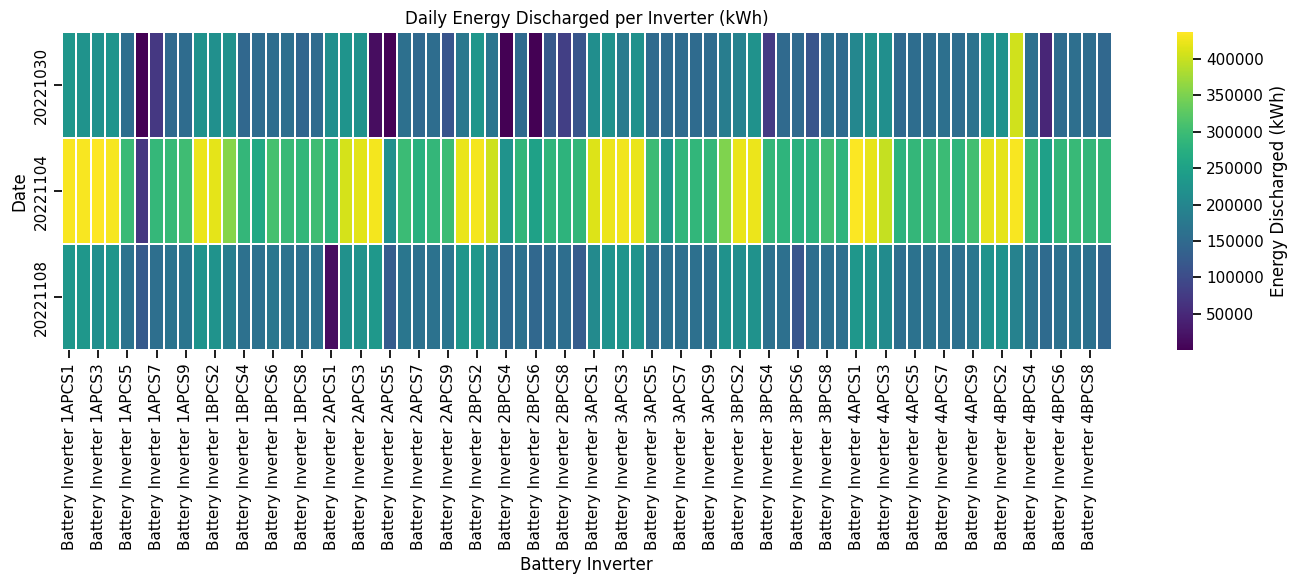

In [12]:
plt.figure(figsize=(14, 6))
sns.heatmap(
    discharged_grouped,
    cmap="viridis",
    linewidths=0.3,
    cbar_kws={"label": "Energy Discharged (kWh)"}
)
plt.title("Daily Energy Discharged per Inverter (kWh)")
plt.xlabel("Battery Inverter")
plt.ylabel("Date")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [13]:
total_charged = daily_energy_df.xs("charged_kWh", level=1, axis=1).sum()
total_discharged = daily_energy_df.xs("discharged_kWh", level=1, axis=1).sum()

outliers = pd.DataFrame({
    "total_charged_kWh": total_charged,
    "total_discharged_kWh": total_discharged
})

lowest_charged = outliers.sort_values("total_charged_kWh").head(5)
lowest_discharged = outliers.sort_values("total_discharged_kWh").head(5)

print("\nTop 5 BESS enclosures with lowest charged energy:")
print(lowest_charged)

print("\nTop 5 BESS enclosures with lowest discharged energy:")
print(lowest_discharged)



Top 5 BESS enclosures with lowest charged energy:
                                                    total_charged_kWh  \
BESS2 DC Input Power (kW) [Battery Inverter 1AP...      125222.095758   
BESS2 DC Input Power (kW) [Battery Inverter 2BP...      144876.362543   
BESS2 DC Input Power (kW) [Battery Inverter 1AP...      160363.237305   
BESS1 DC Input Power (kW) [Battery Inverter 1AP...      164675.662401   
BESS1 DC Input Power (kW) [Battery Inverter 2BP...      181037.745708   

                                                    total_discharged_kWh  
BESS2 DC Input Power (kW) [Battery Inverter 1AP...          93604.904160  
BESS2 DC Input Power (kW) [Battery Inverter 2BP...         158959.333367  
BESS2 DC Input Power (kW) [Battery Inverter 1AP...         223799.629297  
BESS1 DC Input Power (kW) [Battery Inverter 1AP...         100475.937491  
BESS1 DC Input Power (kW) [Battery Inverter 2BP...         183610.433100  

Top 5 BESS enclosures with lowest discharged energy:
      